In [36]:
import helper.batterystats as bstats
import helper.cliffs_delta as cliff
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics, os, re

# Sample app analysis

## Load and prepare battery data

In [37]:
battery_raw_data = bstats.parse_files("./data/sample_apps")

In [38]:
battery_data = {}

relevant_interactions = ["OpenCloseDrawerInteractionTest", "ScrollDownListInteractionTest", "SwitchScreensInteractionTest", "EnterFormDataInteractionTest"]

interaction_names = {
    "OpenCloseDrawerInteractionTest": "Open/close drawer (i1)",   
    "ScrollDownListInteractionTest": "List scrolling (i2)",
    "SwitchScreensInteractionTest": "Switch screens (i3)",
    "EnterFormDataInteractionTest": "Enter form data (i4)",
}

device_names = ["SM-G960F", "SM-G991B"]

app_names = {
    "chrome": "PWA (Chrome)",
    "firefox": "PWA (Firefox)",
    "react": "React Native",
    "flutter": "Flutter",
    "native": "Android native",
    "capacitor": "Capacitor",
    "gecko-wrapper": "PWA (Gecko Wrapper)",
    "webview-wrapper": "PWA (WebView Wrapper)"
}

app_index = {
    "chrome": 0,
    "react": 6,
    "flutter": 5,
    "native": 7,
    "capacitor": 4,
    "firefox": 1,
    "gecko-wrapper": 2,
    "webview-wrapper": 3
}

for device, apps in battery_raw_data.items():    
    if device not in device_names:
        continue
    
    for app, interactions in apps.items():                
        for interaction, values in interactions.items():
            if interaction not in relevant_interactions:
                continue
            
            if "{}_{}".format(device, interaction) not in battery_data.keys():
                battery_data["{}_{}".format(device, interaction)] = {
                    "data" : [[],[],[],[],[],[],[],[]],
                    "app": ["","","","","","","",""],
                    "interaction": interaction_names[interaction],
                    "device": device
                }
            
            battery_data["{}_{}".format(device, interaction)]["data"][app_index[app]] = values["app_joule"]
            battery_data["{}_{}".format(device, interaction)]["app"][app_index[app]] = app_names[app]        

## Generate box plot of energy consumption

[]

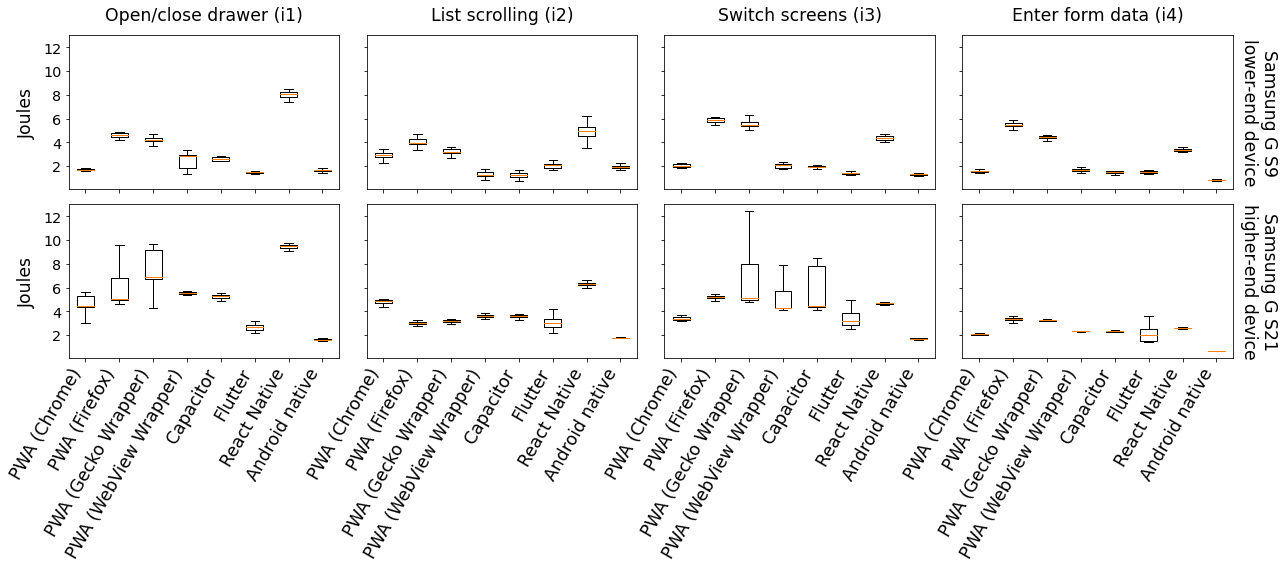

In [39]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(18, 8))

device_labels = {
    "Nexus5X": "Nexus 5X\nlower-end device",
    "SM-G960F": "Samsung G S9\nlower-end device",
    "SM-G991B": "Samsung G S21\nhigher-end device"
}
keys = [    
    "SM-G960F_OpenCloseDrawerInteractionTest",
    "SM-G960F_ScrollDownListInteractionTest",
    "SM-G960F_SwitchScreensInteractionTest",
    "SM-G960F_EnterFormDataInteractionTest",
    "SM-G991B_OpenCloseDrawerInteractionTest",
    "SM-G991B_ScrollDownListInteractionTest",
    "SM-G991B_SwitchScreensInteractionTest",
    "SM-G991B_EnterFormDataInteractionTest",
]

index = 0
for key in keys:    
    item = battery_data[key]
    
    if item['device'] not in ("SM-G960F", "SM-G991B"):
        continue
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot
    
    if index >= 4:
        axs[index // 4, index % 4].boxplot(item["data"], labels=item["app"], sym="", manage_ticks=True, autorange=True) 
    else:
        axs[index // 4, index % 4].boxplot(item["data"], labels=["", "", "", "", "", "", "", ""], sym="", manage_ticks=True, autorange=True)
        axs[index // 4, index % 4].set_title(item["interaction"], fontsize='xx-large', pad=15)
    
    if index % 4 == 0:
        axs[index // 4, index % 4].set_ylabel("Joules", rotation=90, labelpad=7, fontsize='xx-large')
    
    if index % 4 == 3:
        axs[index // 4, index % 4].yaxis.set_label_position("right")
        axs[index // 4, index % 4].set_ylabel(device_labels[item['device']], rotation=-90, labelpad=45, fontsize='xx-large')
    
    index += 1

for x in range(4):
    for label in axs[1, x].get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')
        label.set_fontsize('xx-large')
        
for y in range(2):
    for label in axs[y, 0].get_yticklabels():
        #label.set_rotation(60)
        #label.set_ha('right')
        label.set_fontsize('x-large')         

        
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig('./figures/results.png', dpi=800)
plt.plot()

## Show voltage differences of devices in sample app scenarios

[]

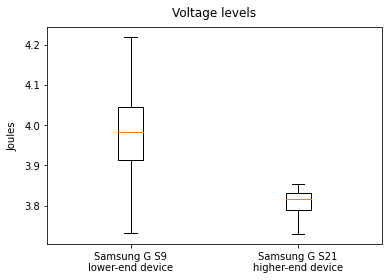

In [40]:
voltage = {
    "SM-G960F": [],
    "SM-G991B": []
}

for device in voltage:
    for app in battery_raw_data[device]:
        for interaction in battery_raw_data[device][app]:
            voltage[device] += battery_raw_data[device][app][interaction]['voltage']

plt.boxplot([voltage["SM-G960F"], voltage["SM-G991B"]], labels=[device_labels["SM-G960F"], device_labels["SM-G991B"]], sym="", manage_ticks=True, autorange=True)
plt.title("Voltage levels", pad=10)
plt.ylabel("Joules", rotation=90, labelpad=7)
plt.savefig('./figures/voltage_levels.png', dpi=800)
plt.plot()            

## Shapiro-Wilk test for normality (sample apps)

`p < 0.05` shows evidence for non-normal distribution

In [41]:
all = 0
non_normal = 0

for key, item in battery_data.items():
    print("{}/{}".format(item["device"], item["interaction"]))
    for app, d in zip(item["app"], item["data"]):
        all += 1
        r = stats.shapiro(np.array(d))
        non_normal += (1 if r[1] <= 0.05 else 0)
        print("  {}: p-value={:.5f}".format(app, r[1]))

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(all - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/all*100))        

SM-G960F/Enter form data (i4)
  PWA (Chrome): p-value=0.12681
  PWA (Firefox): p-value=0.00426
  PWA (Gecko Wrapper): p-value=0.05202
  PWA (WebView Wrapper): p-value=0.69838
  Capacitor: p-value=0.01145
  Flutter: p-value=0.00170
  React Native: p-value=0.11039
  Android native: p-value=0.76389
SM-G960F/Open/close drawer (i1)
  PWA (Chrome): p-value=0.02257
  PWA (Firefox): p-value=0.00000
  PWA (Gecko Wrapper): p-value=0.00248
  PWA (WebView Wrapper): p-value=0.00073
  Capacitor: p-value=0.00001
  Flutter: p-value=0.11752
  React Native: p-value=0.00000
  Android native: p-value=0.94164
SM-G960F/List scrolling (i2)
  PWA (Chrome): p-value=0.03754
  PWA (Firefox): p-value=0.89729
  PWA (Gecko Wrapper): p-value=0.00000
  PWA (WebView Wrapper): p-value=0.69926
  Capacitor: p-value=0.93483
  Flutter: p-value=0.87650
  React Native: p-value=0.68459
  Android native: p-value=0.40298
SM-G960F/Switch screens (i3)
  PWA (Chrome): p-value=0.00000
  PWA (Firefox): p-value=0.00000
  PWA (Gecko W

## Two-sided Mann-Whitney U (sample apps)

 - RQ1: Bonferonni correction means $ a = 0.05/C $, where $ C $ is the number of tests per family (interaction on device)
 - RQ2: Bonferonni correction means $ a = 0.05/C $, where $ C $ is the number of tests per family (interaction on device)

In [42]:
groups = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7]]
rq1_alpha = (0.05 / 4)
rq2_alpha = (0.05 / 3)

keys = [    
    "SM-G960F_OpenCloseDrawerInteractionTest",
    "SM-G960F_ScrollDownListInteractionTest",
    "SM-G960F_SwitchScreensInteractionTest",
    "SM-G960F_EnterFormDataInteractionTest",
    "SM-G991B_OpenCloseDrawerInteractionTest",
    "SM-G991B_ScrollDownListInteractionTest",
    "SM-G991B_SwitchScreensInteractionTest",
    "SM-G991B_EnterFormDataInteractionTest",
]

for key in keys:  
    item = battery_data[key]
    print("{} / {}".format(item["device"], item["interaction"]))
    for group in groups:
        u1 = stats.mannwhitneyu(np.array(item["data"][group[0]]), np.array(item["data"][group[1]]), alternative='two-sided')
        u2 = stats.mannwhitneyu(np.array(item["data"][group[1]]), np.array(item["data"][group[1]]), alternative='two-sided')
        p = u1[1]
        eff1 = cliff.cliffs_delta(item["data"][group[1]], item["data"][group[0]])
        eff2 = ((2 * u1[0]) / (len(item["data"][group[0]]) * len(item["data"][group[1]]))) - 1
        
        print("  {}: PWA (Chrome)/{}: p-value={:.4f}, sig={}, eff={}, interp={}".format(
            "RQ2" if group[1] in (1, 2, 3) else "RQ1",
            item["app"][group[1]],            
            p,
            p < (rq2_alpha if group[1] == 1 else rq1_alpha),
            eff1[0],
            eff1[1]))

SM-G960F / Open/close drawer (i1)
  RQ2: PWA (Chrome)/PWA (Firefox): p-value=0.0000, sig=True, eff=1.0, interp=large
  RQ2: PWA (Chrome)/PWA (Gecko Wrapper): p-value=0.0000, sig=True, eff=1.0, interp=large
  RQ2: PWA (Chrome)/PWA (WebView Wrapper): p-value=0.0000, sig=True, eff=0.82, interp=large
  RQ1: PWA (Chrome)/Capacitor: p-value=0.0000, sig=True, eff=0.7911111111111111, interp=large
  RQ1: PWA (Chrome)/Flutter: p-value=0.0000, sig=True, eff=-0.8311111111111111, interp=large
  RQ1: PWA (Chrome)/React Native: p-value=0.0000, sig=True, eff=1.0, interp=large
  RQ1: PWA (Chrome)/Android native: p-value=0.1023, sig=False, eff=-0.24666666666666667, interp=small
SM-G960F / List scrolling (i2)
  RQ2: PWA (Chrome)/PWA (Firefox): p-value=0.0000, sig=True, eff=0.9844444444444445, interp=large
  RQ2: PWA (Chrome)/PWA (Gecko Wrapper): p-value=0.0006, sig=True, eff=0.5177777777777778, interp=large
  RQ2: PWA (Chrome)/PWA (WebView Wrapper): p-value=0.0000, sig=True, eff=-0.9955555555555555, inte

 ## Effect size heatmap (sample apps)

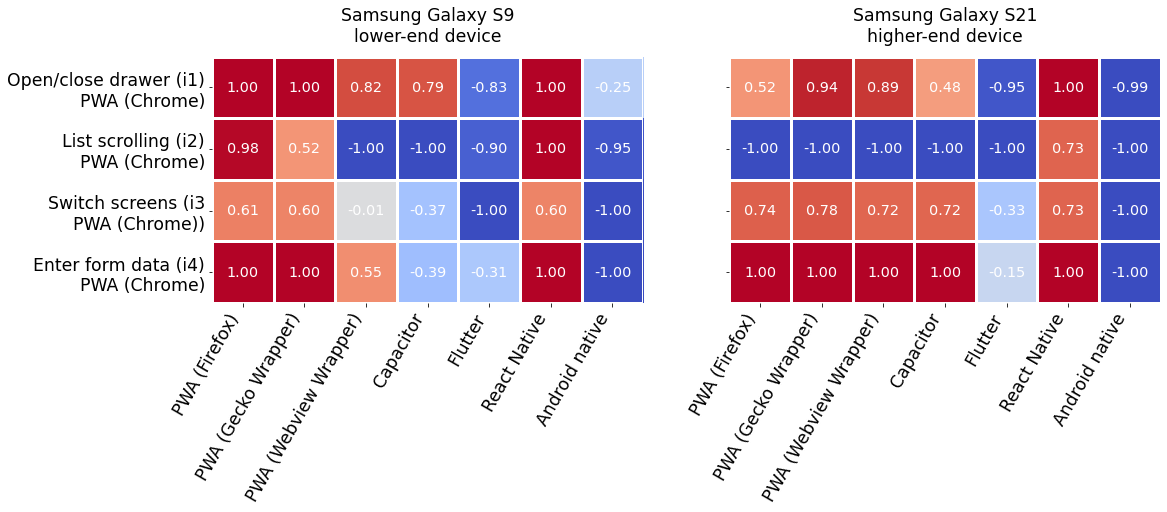

In [43]:
groups = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7]]

app_names = [
    "PWA (Firefox)",
    "PWA (Gecko Wrapper)",
    "PWA (Webview Wrapper)",
    "Capacitor",    
    "Flutter",
    "React Native",    
    "Android native"      
]

interaction_sorting = {
    "Open/close drawer (i1)": 0,   
    "List scrolling (i2)": 1,
    "Switch screens (i3)": 2,
    "Enter form data (i4)": 3,
}

interaction_names = [
    "Open/close drawer (i1)\nPWA (Chrome)",   
    "List scrolling (i2)\nPWA (Chrome)",
    "Switch screens (i3\nPWA (Chrome))",
    "Enter form data (i4)\nPWA (Chrome)",
]

eff_data = {
    "SM-G991B": [[] for i in range(4)],  # rows are interactions, columns are development approaches (aka app)
    "SM-G960F": [[] for i in range(4)]
}

device_labels = {
    "SM-G991B": "Samsung Galaxy S21\nhigher-end device",
    "SM-G960F": "Samsung Galaxy S9\nlower-end device"
}

keys = [
    "SM-G960F_OpenCloseDrawerInteractionTest",
    "SM-G960F_ScrollDownListInteractionTest",
    "SM-G960F_SwitchScreensInteractionTest",
    "SM-G960F_EnterFormDataInteractionTest",
    "SM-G991B_OpenCloseDrawerInteractionTest",
    "SM-G991B_ScrollDownListInteractionTest",
    "SM-G991B_SwitchScreensInteractionTest",
    "SM-G991B_EnterFormDataInteractionTest",    
]

for key in keys:  
    item = battery_data[key]
    #eff_key = item["device"]
    
    for g, group in enumerate(groups):
        eff = cliff.cliffs_delta(item["data"][group[1]], item["data"][group[0]])
        eff_data[item["device"]][interaction_sorting[item['interaction']]].append(eff[0])
        
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, squeeze=True, figsize=(17,5))

for i, key in enumerate(["SM-G960F", "SM-G991B"]):
    data = np.array(eff_data[key])
    im = axs[i].imshow(data, cmap="coolwarm")
    
    # remove grid
    for edge, spine in axs[i].spines.items():
        spine.set_visible(False)        
        
    axs[i].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    axs[i].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    axs[i].grid(which="minor", color="w", linestyle='-', linewidth=3)
    axs[i].tick_params(which="minor", bottom=False, left=False)
    
    axs[i].set_title(device_labels[key], fontsize='xx-large', pad=15)    
    axs[i].set_xticks(np.arange(data.shape[1]))
    axs[i].set_yticks(np.arange(data.shape[0]))
    axs[i].set_xticklabels(app_names)
    
    if i == 0:
        axs[i].set_yticklabels(interaction_names)
        
    #plt.setp(axs[i].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
        
    for c in range(7):
        for r in range(4):
            text = axs[i].text(c, r, "{:.2f}".format(data[r, c]), ha="center", va="center", color="w", fontsize="x-large")
            
#fig.colorbar(im, ax=axs, use_gridspec=True)
        
for i in range(2):
    for label in axs[i].get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')
        label.set_fontsize('xx-large')  
        
for label in axs[0].get_yticklabels():
    label.set_fontsize('xx-large')
        
#fig.subplots_adjust(hspace=0.1)

fig.savefig('figures/heatmap.png', dpi=800, bbox_inches = "tight")

# Real-world app analysis

## Load and prepare battery data

In [44]:
battery_raw_data = bstats.parse_files("./data/real_world_apps/")

In [45]:
data = {}
data_aggregated = {}

devices = [
    "SM-G960F",
    "SM-G991B"
]

app_index = [
    'pwachrome',
    'pwafirefox',
    'hybrid',
    'flutter',
    'reactnative',
    'androidnative'
]

# frame structure
# device, app, interaction, joule

def map_to_technology(app):
    if app in ('fdroid', 'tinyweather', 'newpipe'):
        return 'androidnative'
    elif app in ('bustimetable', 'ulangi', 'yummeals'):
        return 'reactnative'
    elif app in ('aliexpress', 'swiggy', 'versus'):
        return 'pwachrome'
    elif app in ('aliexpressfirefox', 'swiggyfirefox', 'versusfirefox'):
        return 'pwafirefox'
    elif app in ('flutterebook', 'metalreleases', 'allman'):
        return 'flutter'
    elif app in ('sworkit', 'justwatch', 'untapped'):
        return 'hybrid'
    else:
        return 'unknown'

    
for device in battery_raw_data:
    for app in battery_raw_data[device]:
        for interaction in battery_raw_data[device][app]:

            data_points = battery_raw_data[device][app][interaction]['app_joule']
            
            
           
            key = device + "_" + app
            technology = map_to_technology(app)
            key_aggregated = device + "_" + technology
            
            if key_aggregated not in data:
                data[key_aggregated] = {}
            if app not in data[key_aggregated]:
                data[key_aggregated][app] = []
            if key_aggregated not in data_aggregated:
                data_aggregated[key_aggregated] = []

            data[key_aggregated][app] += data_points
            data_aggregated[key_aggregated] += data_points
            
prepared_data = {}

for d in devices:
    prepared_data[d] = []
    for app in app_index:
        key = d + "_" + app
        if key in data_aggregated:        
            prepared_data[d].append(data_aggregated[key])           

## Generate box plot of energy consumption

[]

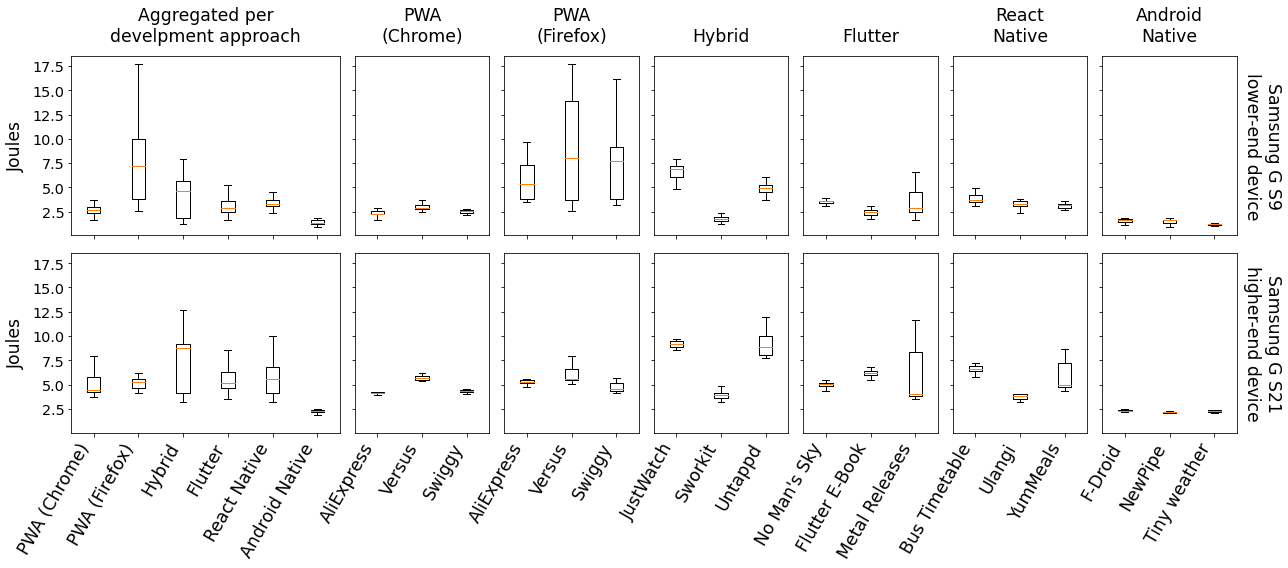

In [46]:
fig, axs = plt.subplots(2, 7, sharey=True, figsize=(18, 8), gridspec_kw={'width_ratios': [2,1,1,1,1,1,1]})

app_data = [
    [
        data['SM-G960F_pwachrome']['aliexpress'],
        data['SM-G960F_pwachrome']['versus'],
        data['SM-G960F_pwachrome']['swiggy']
    ],
    [
        data['SM-G960F_pwafirefox']['aliexpressfirefox'],
        data['SM-G960F_pwafirefox']['versusfirefox'],
        data['SM-G960F_pwafirefox']['swiggyfirefox']
    ],
    [
        data['SM-G960F_hybrid']['justwatch'],
        data['SM-G960F_hybrid']['sworkit'],
        data['SM-G960F_hybrid']['untapped']
    ],
    [
        data['SM-G960F_flutter']['allman'],
        data['SM-G960F_flutter']['flutterebook'],
        data['SM-G960F_flutter']['metalreleases']
    ],
    [
        data['SM-G960F_reactnative']['bustimetable'],
        data['SM-G960F_reactnative']['ulangi'],
        data['SM-G960F_reactnative']['yummeals']
    ],
    [
        data['SM-G960F_androidnative']['fdroid'],
        data['SM-G960F_androidnative']['newpipe'],
        data['SM-G960F_androidnative']['tinyweather']
    ],
    
    # 2nd device
    
    [
        data['SM-G991B_pwachrome']['aliexpress'],
        data['SM-G991B_pwachrome']['versus'],
        data['SM-G991B_pwachrome']['swiggy']
    ],
    [
        data['SM-G991B_pwafirefox']['aliexpressfirefox'],
        data['SM-G991B_pwafirefox']['versusfirefox'],
        data['SM-G991B_pwafirefox']['swiggyfirefox']
    ],
    [
        data['SM-G991B_hybrid']['justwatch'],
        data['SM-G991B_hybrid']['sworkit'],
        data['SM-G991B_hybrid']['untapped']
    ],
    [
        data['SM-G991B_flutter']['allman'],
        data['SM-G991B_flutter']['flutterebook'],
        data['SM-G991B_flutter']['metalreleases']
    ],
    [
        data['SM-G991B_reactnative']['bustimetable'],
        data['SM-G991B_reactnative']['ulangi'],
        data['SM-G991B_reactnative']['yummeals']
    ],
    [
        data['SM-G991B_androidnative']['fdroid'],
        data['SM-G991B_androidnative']['newpipe'],
        data['SM-G991B_androidnative']['tinyweather']
    ]
    
]

device_labels = {
    "SM-G960F": "Samsung G S9\nlower-end device",
    "SM-G991B": "Samsung G S21\nhigher-end device"
}

app_labels = ['PWA (Chrome)', 'PWA (Firefox)', 'Hybrid', 'Flutter', 'React Native', 'Android Native']

axs[0, 0].set_title("Aggregated per\ndevelpment approach", fontsize='xx-large', pad=15)
axs[0, 0].boxplot(prepared_data['SM-G960F'], labels=["","","","","",""], widths=(.3,.3,.3,.3,.3,.3), sym="", manage_ticks=True, autorange=True)
axs[0, 0].set_ylabel("Joules", rotation=90, labelpad=7, fontsize='xx-large') 

axs[0, 1].set_title("PWA\n(Chrome)", fontsize='xx-large', pad=15)
axs[0, 1].boxplot(app_data[0], labels=["","",""], sym="", manage_ticks=True, autorange=True)

axs[0, 2].set_title("PWA\n(Firefox)", fontsize='xx-large', pad=15)
axs[0, 2].boxplot(app_data[1], labels=["","",""], sym="", manage_ticks=True, autorange=True)

axs[0, 3].set_title("Hybrid", fontsize='xx-large', pad=15)
axs[0, 3].boxplot(app_data[2], labels=["","",""], sym="", manage_ticks=True, autorange=True)

axs[0, 4].set_title("Flutter", fontsize='xx-large', pad=15)
axs[0, 4].boxplot(app_data[3], labels=["","",""], sym="", manage_ticks=True, autorange=True)

axs[0, 5].set_title("React\nNative", fontsize='xx-large', pad=15)
axs[0, 5].boxplot(app_data[4], labels=["","",""], sym="", manage_ticks=True, autorange=True)

axs[0, 6].set_title("Android\nNative", fontsize='xx-large', pad=15)
axs[0, 6].boxplot(app_data[5], labels=["","",""], sym="", manage_ticks=True, autorange=True)

axs[1, 0].boxplot(prepared_data['SM-G991B'], labels=app_labels, widths=(.3,.3,.3,.3,.3,.3), sym="", manage_ticks=True, autorange=True)
axs[1, 0].set_ylabel("Joules", rotation=90, labelpad=7, fontsize='xx-large')

axs[1, 1].boxplot(app_data[6], labels=["AliExpress","Versus","Swiggy"], sym="", manage_ticks=True, autorange=True)
axs[1, 2].boxplot(app_data[7], labels=["AliExpress","Versus","Swiggy"], sym="", manage_ticks=True, autorange=True)
axs[1, 3].boxplot(app_data[8], labels=["JustWatch","Sworkit","Untappd"], sym="", manage_ticks=True, autorange=True)
axs[1, 4].boxplot(app_data[9], labels=["No Man's Sky","Flutter E-Book","Metal Releases"], sym="", manage_ticks=True, autorange=True)
axs[1, 5].boxplot(app_data[10], labels=["Bus Timetable","Ulangi","YumMeals"], sym="", manage_ticks=True, autorange=True)
axs[1, 6].boxplot(app_data[11], labels=["F-Droid","NewPipe","Tiny weather"], sym="", manage_ticks=True, autorange=True)


# Device text

axs[0, 6].yaxis.set_label_position("right")
axs[0, 6].set_ylabel(device_labels['SM-G960F'], rotation=-90, labelpad=45, fontsize='xx-large')

axs[1, 6].yaxis.set_label_position("right")
axs[1, 6].set_ylabel(device_labels['SM-G991B'], rotation=-90, labelpad=45, fontsize='xx-large')

for i in range(7):
    for label in axs[1, i].get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')
        label.set_fontsize('xx-large')
        
for y in range(2):
    for label in axs[y, 0].get_yticklabels():
        #label.set_rotation(60)
        #label.set_ha('right')
        label.set_fontsize('x-large')  

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig('./figures/real_world_results.png', dpi=800)
plt.plot()

    
 

## Shapiro-Wilk test for normality (real-world apps)

`p < 0.05` shows evidence for non-normal distribution

In [47]:
all = 0
non_normal = 0

for device, item in battery_raw_data.items():
    for app, item in item.items():
        technology = map_to_technology(app)
        
        if technology != 'unknown':    
            print("{}/{}".format(device, technology))
            
            data = []
            for interaction, item in item.items():
                data += item['app_joule']
            
            all += 1
            r = stats.shapiro(np.array(data))
            non_normal += (1 if r[1] <= 0.05 else 0)
            print("  {}: p-value={:.5f}".format(app, r[1]))
                        
print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(all - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/all*100))

SM-G960F/pwafirefox
  aliexpressfirefox: p-value=0.00000
SM-G960F/pwachrome
  aliexpress: p-value=0.00000
SM-G960F/flutter
  allman: p-value=0.29214
SM-G960F/reactnative
  bustimetable: p-value=0.00000
SM-G960F/androidnative
  fdroid: p-value=0.13747
SM-G960F/flutter
  flutterebook: p-value=0.00000
SM-G960F/hybrid
  justwatch: p-value=0.00000
SM-G960F/flutter
  metalreleases: p-value=0.00005
SM-G960F/androidnative
  newpipe: p-value=0.16305
SM-G960F/pwafirefox
  swiggyfirefox: p-value=0.02165
SM-G960F/pwachrome
  swiggy: p-value=0.00000
SM-G960F/hybrid
  sworkit: p-value=0.01374
SM-G960F/androidnative
  tinyweather: p-value=0.63129
SM-G960F/reactnative
  ulangi: p-value=0.11971
SM-G960F/hybrid
  untapped: p-value=0.00000
SM-G960F/pwafirefox
  versusfirefox: p-value=0.00064
SM-G960F/pwachrome
  versus: p-value=0.00010
SM-G960F/reactnative
  yummeals: p-value=0.00000
SM-G991B/pwafirefox
  aliexpressfirefox: p-value=0.00000
SM-G991B/pwachrome
  aliexpress: p-value=0.00000
SM-G991B/flutter

## Two-sided Mann-Whitney U (real-world apps)

 - RQ1: Bonferonni correction means $ a = 0.05/C $, where $ C $ is the number of tests per family (interaction on device)
 - RQ2: Bonferonni correction means $ a = 0.05/C $, where $ C $ is the number of tests per family (interaction on device)

In [48]:
groups = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]
rq1_alpha = (0.05 / 4)
rq2_alpha = (0.05)

battery_data = {}

keys = [
    [
        'SM-G960F_pwachrome',
        'SM-G960F_pwafirefox',
        'SM-G960F_hybrid',
        'SM-G960F_flutter',
        'SM-G960F_reactnative',
        'SM-G960F_androidnative',
    ],
    [
        'SM-G991B_pwachrome',
        'SM-G991B_pwafirefox',
        'SM-G991B_hybrid',
        'SM-G991B_flutter',
        'SM-G991B_reactnative',
        'SM-G991B_androidnative',
    ]   
]

for device, item in battery_raw_data.items():
    for app, item in item.items():
        technology = map_to_technology(app)
        
        if technology != 'unknown':
            key = device + "_" + technology
            if key not in battery_data:
                battery_data[key] = []
            
            for interaction, item in item.items():
                battery_data[key] += item['app_joule']

                
for index, device in enumerate(('SM-G960F', 'SM-G991B')):
    print(device)
    
    for group in groups:
        u1 = stats.mannwhitneyu( np.array( battery_data[keys[index][group[0]]] ) , np.array( battery_data[keys[index][group[1]]] ), alternative='two-sided')
        p = u1[1]
        eff1 = cliff.cliffs_delta(battery_data[keys[index][group[1]]], battery_data[keys[index][group[0]]])
        eff2 = ((2 * u1[0]) / (len(battery_data[keys[index][group[0]]]) * len(battery_data[keys[index][group[1]]]))) - 1
        
        print("  {}: PWA (Chrome)/{}: p-value={:.4f}, sig={}, eff={}, interp={}".format(
            "RQ2" if group[1] == 1 else "RQ1",
            keys[index][group[1]],            
            p,
            p < (rq2_alpha if group[1] == 1 else rq1_alpha),
            eff1[0],
            eff1[1]))

SM-G960F
  RQ2: PWA (Chrome)/SM-G960F_pwafirefox: p-value=0.0000, sig=True, eff=0.8386759581881533, interp=large
  RQ1: PWA (Chrome)/SM-G960F_hybrid: p-value=0.0078, sig=True, eff=0.2525, interp=small
  RQ1: PWA (Chrome)/SM-G960F_flutter: p-value=0.0617, sig=False, eff=0.19348370927318295, interp=small
  RQ1: PWA (Chrome)/SM-G960F_reactnative: p-value=0.0000, sig=True, eff=0.6580952380952381, interp=large
  RQ1: PWA (Chrome)/SM-G960F_androidnative: p-value=0.0000, sig=True, eff=-0.9804761904761905, interp=large
SM-G991B
  RQ2: PWA (Chrome)/SM-G991B_pwafirefox: p-value=0.0436, sig=True, eff=0.18216374269005847, interp=small
  RQ1: PWA (Chrome)/SM-G991B_hybrid: p-value=0.0000, sig=True, eff=0.4212234706616729, interp=medium
  RQ1: PWA (Chrome)/SM-G991B_flutter: p-value=0.1298, sig=False, eff=0.1308641975308642, interp=negligible
  RQ1: PWA (Chrome)/SM-G991B_reactnative: p-value=0.0792, sig=False, eff=0.15160493827160493, interp=small
  RQ1: PWA (Chrome)/SM-G991B_androidnative: p-value=0.

 ## Effect size heatmap (real-world apps)

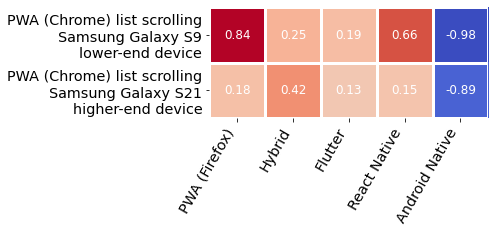

In [49]:
eff_data = {
    'SM-G960F': [0, 0, 0, 0, 0],
    'SM-G991B': [0, 0, 0 ,0, 0]
}

battery_data = {}

app_labels = ['PWA (Firefox)', 'Hybrid', 'Flutter', 'React Native', 'Android Native']

keys = [
    [
        'SM-G960F_pwachrome',
        'SM-G960F_pwafirefox',
        'SM-G960F_hybrid',
        'SM-G960F_flutter',
        'SM-G960F_reactnative',
        'SM-G960F_androidnative',
    ],
    [
        'SM-G991B_pwachrome',
        'SM-G991B_pwafirefox',
        'SM-G991B_hybrid',
        'SM-G991B_flutter',
        'SM-G991B_reactnative',
        'SM-G991B_androidnative',
    ]   
]

for device, item in battery_raw_data.items():
    for app, item in item.items():
        technology = map_to_technology(app)
        
        if technology != 'unknown':
            key = device + "_" + technology
            if key not in battery_data:
                battery_data[key] = []
            
            for interaction, item in item.items():
                battery_data[key] += item['app_joule']

                
for index, device in enumerate(('SM-G960F', 'SM-G991B')):    
    for group in groups:
        u1 = stats.mannwhitneyu( np.array( battery_data[keys[index][group[0]]] ) , np.array( battery_data[keys[index][group[1]]] ), alternative='two-sided')
        p = u1[1]
        eff = cliff.cliffs_delta(battery_data[keys[index][group[1]]], battery_data[keys[index][group[0]]])
        eff_data[device][group[1] - 1] = eff[0]

data = np.array([eff_data['SM-G960F'], eff_data['SM-G991B']])

fig, ax = plt.subplots(squeeze=True, figsize=(5, 3))
im = ax.imshow(data, cmap="coolwarm")

# remove grid
for edge, spine in ax.spines.items():
    spine.set_visible(False)
    
ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[0]))

ax.set_xticklabels(app_labels)
ax.set_yticklabels(["PWA (Chrome) list scrolling\nSamsung Galaxy S9\nlower-end device", "PWA (Chrome) list scrolling\nSamsung Galaxy S21\nhigher-end device"])

for c in range(5):
    for r in range(2):
        text = ax.text(c, r, "{:.2f}".format(data[r, c]), ha="center", va="center", color="w", fontsize="large")

for i in range(2):
    for label in ax.get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')
        label.set_fontsize('x-large')  
        
for label in ax.get_yticklabels():
    label.set_fontsize('x-large')
    
fig.savefig('figures/heatmap2.png', dpi=800, bbox_inches = "tight")